# **Diffusion-SVC**
## Last Updated: Jun 26, 2023

# 1.Install the project

In [ ]:
#@title Check the graphics card
!nvidia-smi

In [ ]:
#@title Install dependencies
!apt update
!apt install python3.10
!pip3 install --upgrade pip
%cd /content
!git clone https://github.com/CNChTu/Diffusion-SVC.git
%cd Diffusion-SVC
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip3 install -r requirements.txt
!pip3 install tensorboard

In [ ]:
#@title Download encoder and decoder
!mkdir /content/Diffusion-SVC/pretrain/contentvec
!mkdir /content/Diffusion-SVC/exp/naive-test
!wget -O /content/Diffusion-SVC/pretrain/contentvec/checkpoint_best_legacy_500.pt https://huggingface.co/OOPPEENN/encoder_model/resolve/main/hubert_base.pt
!wget -O /content/Diffusion-SVC/pretrain/nsf_hifigan_20221211.zip https://github.com/openvpi/vocoders/releases/download/nsf-hifigan-v1/nsf_hifigan_20221211.zip
!unzip -o -d /content/Diffusion-SVC/pretrain /content/Diffusion-SVC/pretrain/nsf_hifigan_20221211.zip
!rm -rf /content/Diffusion-SVC/pretrain/nsf_hifigan_20221211.zip

# Choose one of the following three options

In [ ]:
#@title Download the pretrained model, shallow diffusion, maximum diffusion depth of 100, network size 512x30 (recommended).
!wget -O /content/Diffusion-SVC/exp/diffusion-test/model_0.pt https://huggingface.co/OOPPEENN/pretrained_model/resolve/main/contentvec768l12_shallow_k100_512x30_model_0.pt
!wget -O /content/Diffusion-SVC/exp/naive-test/model_0.pt https://huggingface.co/OOPPEENN/pretrained_model/resolve/main/contentvec768l12_naive_model_0.pt

In [ ]:
#@title Download the pretrained model, shallow diffusion, maximum diffusion depth of 200, network size 512x20 (recommended).
!wget -O /content/Diffusion-SVC/exp/diffusion-test/model_0.pt https://huggingface.co/OOPPEENN/pretrained_model/resolve/main/contentvec768l12_shallow_k200_512x20_model_0.pt
!wget -O /content/Diffusion-SVC/exp/naive-test/model_0.pt https://huggingface.co/OOPPEENN/pretrained_model/resolve/main/contentvec768l12_naive_model_0.pt

In [ ]:
#@title Download the pretrained model, full diffusion, network size 512x20
!wget -O /content/Diffusion-SVC/exp/diffusion-test/model_0.pt https://huggingface.co/OOPPEENN/pretrained_model/resolve/main/contentvec768l12_full_512x20_model_0.pt
!wget -O /content/Diffusion-SVC/exp/naive-test/model_0.pt https://huggingface.co/OOPPEENN/pretrained_model/resolve/main/contentvec768l12_naive_model_0.pt

# 2.Upload the dataset

1. Resample all .wav audio files to 44.1kHz using tools like Adobe Audition™ or similar software locally.

2. Slice the dataset locally using [Slicer](https://github.com/flutydeer/audio-slicer). Ensure that the maximum duration of each audio segment does not exceed 15 seconds. It is strongly recommended to discard audio segments that are less than 2 seconds long.

3. Place the sliced training dataset (in .wav format) locally in the directory `data/train/audio`.

4. Randomly select and copy 6 audio segments from the training dataset locally to the directory `data/train/val` for use as the validation set.

**Speaker IDs must start from 1 and should not start from 0. If there is only one speaker, the speaker ID must be 1.**


The directory structure of the dataset is as follows:

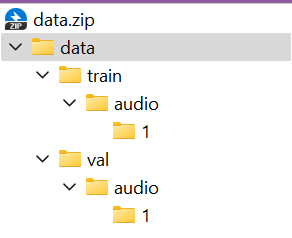
```
data.zip
|
data
|
├─ train
│    ├─ audio
│    │    ├─ 1
│    │    │   ├─ aaa.wav
│    │    │   ├─ bbb.wav
│    │    │   └─ ....wav
│    │    ├─ 2
│    │    │   ├─ ccc.wav
│    │    │   ├─ ddd.wav
│    │    │   └─ ....wav
│    │    └─ ...
|
├─ val
|    ├─ audio
│    │    ├─ 1
│    │    │   ├─ eee.wav
│    │    │   ├─ fff.wav
│    │    │   └─ ....wav
│    │    ├─ 2
│    │    │   ├─ ggg.wav
│    │    │   ├─ hhh.wav
│    │    │   └─ ....wav
│    │    └─ ...
```
3. Compress the locally constructed dataset into a zip file and upload it to the root directory of Google Drive.


In [ ]:
#@title Upload dataset from Google Drive
from google.colab import drive
drive.mount('/content/drive')
#@markdown Dataset location
DATASET = "/content/drive/MyDrive/data.zip"  #@param {type:"string"}

!unzip -d /content/Diffusion-SVC -B {DATASET}

# 3. Modify configuration file & preprocess

In [ ]:
#@title Modify and save the configuration file for shallow diffusion (recommended, must be used in conjunction with the naive model, modify and run this cell to confirm)

#@markdown f0 extractor (choose 'crepe' for noisy datasets, 'parselmouth' recommended otherwise, choose 'dio' for speed)
f0_extractor = "crepe"  #@param ['dio', 'parselmouth', 'harvest', 'crepe']

#@markdown Number of layers, consistent with the downloaded pretrained model
n_layers = 30  #@param {type:"integer"}

#@markdown Number of channels, consistent with the downloaded pretrained model
n_chans = 512  #@param {type:"integer"}

#@markdown  Maximum diffusion depth, consistent with the downloaded pretrained model (not to exceed 999)
k_step_max = 200  #@param {type:"integer"}

#@markdown Number of threads used for loading the dataset (usually 4 is sufficient)
num_workers = 4  #@param {type:"integer"}

#@markdown Training precision, fp16 recommended for T4 GPUs, if training fails (loss=1), you can try modifying the learning rate
amp_dtype = "fp16"  #@param ['fp32', 'bf16', 'fp16']

#@markdown Batch size, keep the default value
batch_size = 48  #@param {type:"integer"}

#@markdown Learning rate, keep the default value
lr = 0.0001  #@param {type:"number"}

#@markdown Learning rate decay steps, every n steps, the learning rate is halved
decay_step = 20000  #@param {type:"integer"}

#@markdown Cache the dataset in memory or on the GPU (prefer GPU, then memory, or disable caching if insufficient)
cache_device = cuda #@param ['cpu', 'cuda']

#@markdown Cache the entire dataset in memory or on the GPU (disable if GPU or memory usage is excessive)
cache_all_data = True #@param {type:"boolean"}

#@markdown Training log interval (in steps), avoid setting it too small, beware of large log sizes
interval_log = 100  #@param {type:"integer"}

#@markdown Validation interval (in steps), avoid setting it too small, as it significantly slows down training speed
interval_val = 5000  #@param {type:"integer"}

#@markdown Model saving interval (in steps), avoid setting it too small, beware of insufficient disk space
interval_force_save = 5000  #@param {type:"integer"}

import os
import yaml

folder_path = "/content/Diffusion-SVC/data/train/audio"
folders = [name for name in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, name))]

with open("/content/Diffusion-SVC/configs/config_shallow.yaml", "r") as diff:
    existing_config = yaml.safe_load(diff)
existing_config["data"]["f0_extractor"] = f0_extractor
existing_config["model"]["n_layers"] = n_layers
existing_config["model"]["n_chans"] = n_chans
existing_config["model"]["k_step_max"] = k_step_max
existing_config["model"]["n_spk"] = len(folders)
existing_config["train"]["num_workers"] = num_workers
existing_config["train"]["amp_dtype"] = amp_dtype
existing_config["train"]["batch_size"] = batch_size
existing_config["train"]["lr"] = lr
existing_config["train"]["decay_step"] = decay_step
existing_config["train"]["cache_device"] = cache_device
existing_config["train"]["cache_all_data"] = cache_all_data
existing_config["train"]["interval_log"] = interval_log
existing_config["train"]["interval_val"] = interval_val
existing_config["train"]["interval_force_save"] = interval_force_save
with open("/content/Diffusion-SVC/configs/config_shallow.yaml", "w") as diff:
    yaml.dump(existing_config, diff)

In [ ]:
#@title Modify and save the configuration file for the naive model

#@markdown f0 extractor (choose 'crepe' for noisy datasets, 'parselmouth' recommended otherwise, choose 'dio' for speed)
f0_extractor = "crepe"  #@param ['dio', 'parselmouth', 'harvest', 'crepe']

#@markdown Number of threads used for loading the dataset (usually 4 is sufficient)
num_workers = 4  #@param {type:"integer"}

#@markdown Batch size, keep the default value
batch_size = 48  #@param {type:"integer"}

#@markdown Learning rate, keep the default value
lr = 0.0005  #@param {type:"number"}

#@markdown Learning rate decay steps, every n steps, the learning rate is halved
decay_step = 10000  #@param {type:"integer"}

#@markdown Cache the dataset in memory or on the GPU (prefer GPU, then memory, or disable caching if insufficient)
cache_device = cuda #@param ['cpu', 'cuda']

#@markdown Cache the entire dataset in memory or on the GPU (disable if GPU or memory usage is excessive)
cache_all_data = True #@param {type:"boolean"}

#@markdown Training log interval (in steps), avoid setting it too small, beware of large log sizes
interval_log = 100  #@param {type:"integer"}

#@markdown Validation interval (in steps), avoid setting it too small, as it significantly slows down training speed
interval_val = 5000  #@param {type:"integer"}

#@markdown Model saving interval (in steps), avoid setting it too small, beware of insufficient disk space
interval_force_save = 5000  #@param {type:"integer"}

import os
import yaml

folder_path = "/content/Diffusion-SVC/data/train/audio"
folders = [name for name in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, name))]

with open("/content/Diffusion-SVC/configs/config_naive.yaml", "r") as diff:
    existing_config = yaml.safe_load(diff)
existing_config["data"]["f0_extractor"] = f0_extractor
existing_config["model"]["n_spk"] = len(folders)
existing_config["train"]["num_workers"] = num_workers
existing_config["train"]["batch_size"] = batch_size
existing_config["train"]["lr"] = lr
existing_config["train"]["decay_step"] = decay_step
existing_config["train"]["cache_device"] = cache_device
existing_config["train"]["cache_all_data"] = cache_all_data
existing_config["train"]["interval_log"] = interval_log
existing_config["train"]["interval_val"] = interval_val
existing_config["train"]["interval_force_save"] = interval_force_save
with open("/content/Diffusion-SVC/configs/config_naive.yaml", "w") as diff:
    yaml.dump(existing_config, diff)

In [ ]:
#@title Modify and save the configuration file for full diffusion (modify and run this cell to confirm)

#@markdown f0 extractor (choose 'crepe' for noisy datasets, 'parselmouth' recommended otherwise, choose 'dio' for speed)
f0_extractor = "crepe"  #@param ['dio', 'parselmouth', 'harvest', 'crepe']

#@markdown Number of layers, consistent with the downloaded pretrained model
n_layers = 20  #@param {type:"integer"}

#@markdown Number of channels, consistent with the downloaded pretrained model
n_chans = 512  #@param {type:"integer"}

#@markdown Number of threads used for loading the dataset (usually 4 is sufficient)
num_workers = 4  #@param {type:"integer"}

#@markdown Training precision, fp16 recommended for T4 GPUs, if training fails (loss=1), you can try modifying the learning rate
amp_dtype = "fp16"  #@param ['fp32', 'bf16', 'fp16']

#@markdown Batch size, keep the default value
batch_size = 48  #@param {type:"integer"}

#@markdown Learning rate, keep the default value
lr = 0.0002  #@param {type:"number"}

#@markdown Learning rate decay steps, every n steps, the learning rate is halved
decay_step = 100000  #@param {type:"integer"}

#@markdown Cache the dataset in memory or on the GPU (prefer GPU, then memory, or disable caching if insufficient)
cache_device = cuda #@param ['cpu', 'cuda']

#@markdown Cache the entire dataset in memory or on the GPU (disable if GPU or memory usage is excessive)
cache_all_data = True #@param {type:"boolean"}

#@markdown Training log interval (in steps), avoid setting it too small, beware of large log sizes
interval_log = 100  #@param {type:"integer"}

#@markdown Validation interval (in steps), avoid setting it too small, as it significantly slows down training speed
interval_val = 5000  #@param {type:"integer"}

#@markdown Model saving interval (in steps), avoid setting it too small, beware of insufficient disk space
interval_force_save = 5000  #@param {type:"integer"}

import os
import yaml

folder_path = "/content/Diffusion-SVC/data/train/audio"
folders = [name for name in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, name))]

with open("/content/Diffusion-SVC/configs/config.yaml", "r") as diff:
    existing_config = yaml.safe_load(diff)
existing_config["data"]["f0_extractor"] = f0_extractor
existing_config["model"]["n_layers"] = n_layers
existing_config["model"]["n_chans"] = n_chans
existing_config["model"]["n_spk"] = len(folders)
existing_config["train"]["num_workers"] = num_workers
existing_config["train"]["amp_dtype"] = amp_dtype
existing_config["train"]["batch_size"] = batch_size
existing_config["train"]["lr"] = lr
existing_config["train"]["decay_step"] = decay_step
existing_config["train"]["cache_device"] = cache_device
existing_config["train"]["cache_all_data"] = cache_all_data
existing_config["train"]["interval_log"] = interval_log
existing_config["train"]["interval_val"] = interval_val
existing_config["train"]["interval_force_save"] = interval_force_save
with open("/content/Diffusion-SVC/configs/config.yaml", "w") as diff:
    yaml.dump(existing_config, diff)


In [ ]:
#@title Preprocess the dataset using the configuration file for shallow diffusion
!python preprocess.py -c /content/Diffusion-SVC/configs/config_shallow.yaml

In [ ]:
#@title Preprocess the dataset using the configuration file for full diffusion
!python preprocess.py -c /content/Diffusion-SVC/configs/config.yaml

# 4. Start training

In [ ]:
#@title Train the shallow diffusion model (recommended, can only be used in combination with the naive model, choose either the full diffusion model or the shallow diffusion model)
%load_ext tensorboard
%tensorboard --logdir /content/Diffusion-SVC/exp
!python train.py -c /content/Diffusion-SVC/configs/config_shallow.yaml

In [ ]:
#@title Train the Naive model (full diffusion model optional, shallow diffusion required)
%load_ext tensorboard
%tensorboard --logdir /content/Diffusion-SVC/exp
!python train.py -c /content/Diffusion-SVC/configs/config_naive.yaml

In [ ]:
#@title Train the full diffusion model
%load_ext tensorboard
%tensorboard --logdir /content/Diffusion-SVC/exp
!python train.py -c /content/Diffusion-SVC/configs/config.yaml

# 5. Process the model

In [ ]:
#@title Merge Diffusion and Naive Models

#@markdown Select Diffusion model (copy and paste the complete file path from the file page)
Diffusion_model = "/content/Diffusion-SVC/exp/diffusion-test/model_xxxx.pt"  #@param{type:"string"}

#@markdown Select Naive model (copy and paste the complete file path from the file page)
Naive_model = "/content/Diffusion-SVC/exp/naive-test/model_xxxx.pt"  #@param{type:"string"}

#@markdown Output folder for the merged model
output_folder = "/content/drive/MyDrive/"  #@param{type:"string"}

#@markdown Name of the merged model
name = "combine"  #@param{type:"string"}

!python combo.py -model {Diffusion_model} -nmodel {Naive_model} -exp {output_folder} -n {name}

# 6. Inference


In [ ]:
#@title Non-real-time Inference
#@markdown Select the audio file for inference (place it in the root directory of Google Drive and modify the audio name)
input_wav = "/content/drive/MyDrive/input.wav"  #@param{type:"string"}

#@markdown Select the output directory for the inference result
output_wav = "/content/drive/MyDrive/output.wav"  #@param{type:"string"}

#@markdown Path to the Diffusion model or the combined model
combine_model = "/content/drive/MyDrive/combine.ptc"  #@param{type:"string"}

#@markdown Pitch shift
keychange = 0  #@param {type:"integer"}

#@markdown Speaker ID
speaker_id = 1  #@param {type:"integer"}

#@markdown Speedup factor
speedup = 10  #@param {type:"integer"}

#@markdown Sampling method
method = "dpm-solver"  #@param ['pndm', 'ddim', 'unipc', 'dpm-solver']

#@markdown Shallow diffusion steps (should not exceed k_step_max set in Step 2 for shallow diffusion models, and not exceed 1000 for complete diffusion models)
kstep = 200  #@param {type:"integer"}

!python main.py -i {input_wav} -model {combine_model} -o {output_wav} -k {keychange} -id {speaker_id} -speedup {speedup} -method {method} -kstep {kstep}